In [134]:
import pandas as pd
import numpy as np
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
import shap
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import random
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, classification_report, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.decomposition import NMF, PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import LeaveOneOut
from sklearn.feature_selection import f_classif, SelectFdr, SelectPercentile, SelectFwe
from scipy import stats


random_seed = 42

In [135]:
# Get combined data for training from utility function
CURRENT_DIR = os.getcwd()

os.chdir("..")
from ccrcc_preprocessing import preprocessed_data
df = preprocessed_data()
os.chdir(CURRENT_DIR)

In [136]:
glycoform_df = df.iloc[:,1:10815]
glycoform_df

,ITIH2_113_GAFISnFSMTVDGK_126_6_N4H5F0S1G0,APMAP_196_nMSFVNDLTVTQDGRK_211_1_N2H8F0S0G0,FN1_535_HEEGHMLnCTCFGQGR_550_8_N4H5F0S1G0,CD109_286_InGSANFSFNDEEMK_300_2_N2H8F0S0G0,PLXNB2_1031_EAESLQPMTVVGTDYVFHnDTK_1052_19_N5H5F1S0G0,CTSC_51_DVnCSVMGPQEK_62_3_N4H6F0S0G0,FGB_375_YRGTAGNALMDGASQLMGEnR_395_20_N4H5F0S1G0,CLU_97_ELPGVCnETMMALWEECKPCLK_118_7_N4H5F0S2G0,P4HA1_105_DMSDGFISnLTIQR_118_9_N2H6F0S0G0,CLU_352_MLnTSSLLEQLNEQFNWVSR_371_3_N4H5F0S1G0,...,BTD_340_NPVGLIGAEnATGETDPSHSK_360_10_N2H5F0S0G0,GNS_356_GPGIKPnQTSK_366_7_N2H5F0S0G0,SERPINA1_64_QLAHQSnSTNIFFSPVSIATAFAMLSLGTK_93_7_N5H5F0S2G0,OLFML3_169_IYVLDGTQnDTAFVFPR_185_9_N4H5F1S0G0,FGG_65_DLQSLEDILHQVEnK_79_14_N5H6F1S1G0,LAMA5_3244_LLLGGLPESGTIYnFSGCISNVFVQR_3269_14_N3H5F0S1G0,CDH6_394_EDAQInTTIGSVTAQDPDAAR_414_6_N5H5F2S0G0,STAB1_1726_RnVTAAAQGFGYK_1738_2_N2H8F0S0G0,TFRC_242_DFEDLYTPVnGSIVIVR_258_10_N5H5F1S2G0,LGALS3BP_64_ALGFEnATQALGR_76_6_N4H5F0S2G0
0,17.194097,16.141039,14.363901,16.82315,14.832855,13.05617,16.359029,17.979474,16.248994,15.285534,...,15.595219,16.896178,14.7729,17.00951,17.00063,14.867106,16.117845,14.476855,13.869988,15.641613
1,17.326459,16.635474,14.500603,17.325074,14.425776,12.412877,16.231234,17.220815,17.775143,14.915579,...,14.813011,17.535315,14.475654,16.276239,16.769055,15.014174,15.494352,17.058441,15.707804,16.001312
2,17.161645,16.457631,14.414845,16.708205,14.883942,13.579303,15.945842,17.658734,16.499878,15.484552,...,15.522371,17.969214,14.03173,17.223192,15.992055,14.887579,16.258365,14.707436,13.973556,15.549608
3,17.531468,17.102947,14.800264,18.149726,14.342608,12.847752,16.09394,17.740037,17.990332,15.702056,...,14.86381,15.89373,14.174981,16.085713,16.342642,14.39218,15.445131,16.038721,13.995085,15.860276
4,18.490422,16.398802,15.219195,16.910034,14.234945,12.150975,15.950968,16.888709,17.698439,15.729211,...,14.752897,15.085696,14.938215,16.071357,16.33028,14.883073,15.729901,15.13648,14.661459,16.076735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,17.712529,15.843208,14.641417,17.100007,14.74174,11.287389,15.585231,17.039707,17.340122,15.731551,...,14.751935,15.918554,15.282739,16.357851,16.263307,15.353862,15.329724,16.139644,13.847798,16.490557
179,17.954562,16.001401,14.935134,16.855874,14.341116,11.059163,15.455444,17.018237,17.432247,15.261726,...,14.944425,17.023322,14.283089,17.317535,15.409376,14.876406,15.053775,15.552114,14.180602,16.364148
180,17.892701,15.250424,15.268693,17.133722,14.606062,14.117903,16.026908,18.260688,16.242812,15.861118,...,15.755052,17.782899,14.774031,17.353575,15.470574,15.692505,15.718774,14.379797,13.688188,16.246464
181,18.296734,15.964142,14.425399,17.198116,15.357927,11.403616,15.502065,16.530029,17.593074,15.630206,...,14.596866,15.774534,15.081243,16.64235,16.043253,14.89774,15.759281,15.647152,14.429359,17.212025


In [137]:
#Shapiro-Wilk Test for normality
from scipy.stats import shapiro 

abundance_stats = {"feature":[], "pval":[]}
for col in glycoform_df.columns:
    stat, pval = shapiro(glycoform_df[col])
    abundance_stats["feature"].append(col)
    abundance_stats["pval"].append(pval)

pvals = pd.DataFrame(abundance_stats)
not_normal = pvals[pvals["pval"]<0.05].sort_values(by="pval")
not_normal

,feature,pval
3118,C1RL_155_GFLALYQTVAVnYSQPISEASR_176_12_N4H5F2S1G0,1.092225e-26
4357,VTN_242_nISDGFDGIPDNVDAALALPAHSYSGR_268_1_N4H5...,1.118371e-25
5731,PGAP3_31_DCVLQCEEQnCSGGALNHFR_50_10_N2H8F0S0G0,1.378924e-25
2591,CLN5_251_NIETnYTR_258_5_N2H8F0S0G0,2.679858e-25
8050,LAMB2_1346_RAnTSALAVPSPVSNSASAR_1365_3_N2H8F0S0G0,2.832521e-25
...,...,...
3076,PTTG1IP_54_nVSCLWCNTNK_64_1_N2H9F0S0G0,4.986221e-02
2646,HPX_447_ALPQPQnVTSLLGCTH_462_7_N7H5F0S0G0,4.988007e-02
1523,LAMP2_88_IAVQFGPGFSWIAnFTK_104_14_N7H8F0S2G0,4.988221e-02
7074,LAMP1_255_LLNINPnK_262_7_N2H6F0S0G0,4.989312e-02


In [138]:
#cor_df = pd.DataFrame(glycoform_df.corr())
#max_cor = abs(cor_df.replace(1.000000, np.nan)).describe().iloc[-1]


In [139]:
#max_cor[max_cor>0.7]

## All Glycoforms

In [140]:
def get_glycoforms():

    site_dict = {}

    for i in glycoform_df.columns:
        row = i.split("_")
        gene, pep_start, sequence, gly_site, glycan = row[0], int(row[1]), row[2], int(row[4]), row[5]
        glycosylation_site = pep_start + gly_site - 1
    
        glycosite = gene + "_" + str(glycosylation_site) + "_" + glycan

        if glycosite not in site_dict:
            site_dict[glycosite] = [i]

        else:
            site_dict[glycosite].append(i)

    df_dict = {}

    for key,value in site_dict.items():
        df_dict[key] = glycoform_df[value].sum(axis=1)


    return pd.DataFrame(df_dict)

## Glycosites

In [141]:
def get_glycosites():

    site_dict = {}

    for i in glycoform_df.columns:
        row = i.split("_")
        gene, pep_start, sequence, gly_site, glycan = row[0], int(row[1]), row[2], int(row[4]), row[5]
        glycosylation_site = pep_start + gly_site - 1

        glycosite = gene + "_" + str(glycosylation_site)

        if glycosite not in site_dict:
            site_dict[glycosite] = [i]
        
        else: 
            site_dict[glycosite].append(i)

    df_dict = {}

    for key,value in site_dict.items():
        df_dict[key] = glycoform_df[value].sum(axis=1)


    return pd.DataFrame(df_dict)

## Glycosite with type

In [142]:
def get_glycotype():

    site_dict = {}

    for i in glycoform_df.columns:
        row = i.split("_")
        gene, pep_start, sequence, gly_site, glycan = row[0], int(row[1]), row[2], int(row[4]), row[5]
        glycosylation_site = pep_start + gly_site - 1

        glycosite = gene + "_" + str(glycosylation_site)

        if glycosite not in site_dict:

            site_dict[glycosite] = [] # keep this row
            site_dict[glycosite+'_fucosylated'] = []
            site_dict[glycosite+'_sialylated'] = []
            site_dict[glycosite+'_fuc_and_sialyl'] = []
            site_dict[glycosite+'_highmannose'] = []
            site_dict[glycosite+'_complex-asialyl-no-fuc'] = []
    
        if "F0" not in glycan and "S0" in glycan: site_dict[glycosite+'_fucosylated'].append(i)
        elif "S0" not in glycan and "F0" in glycan: site_dict[glycosite+'_sialylated'].append(i)
        elif "F0" not in glycan and "S0" not in glycan: site_dict[glycosite+'_fuc_and_sialyl'].append(i)
        else:
            if "N2" in glycan: 
                site_dict[glycosite+'_highmannose'].append(i)
            else: 
                site_dict[glycosite+'_complex-asialyl-no-fuc'].append(i)

    df_dict = {}

    for key,value in site_dict.items():
        if len(value) == 0:
            continue
        df_dict[key] = glycoform_df[value].sum(axis=1)


    return pd.DataFrame(df_dict)

## Process metadata

In [143]:
metadata = df.iloc[:,10816:]
metadata.columns

Index(['aliquot submitter id', 'sample id', 'sample submitter id', 'case id',
       'case submitter id', 'project name', 'sample type', 'primary site',
       'disease type', 'aliquot is ref',
       ...
       'risk factor treatment', 'scan tracer used',
       'undescended testis corrected', 'undescended testis corrected age',
       'undescended testis corrected laterality',
       'undescended testis corrected method', 'undescended testis history',
       'undescended testis history laterality', 'viral hepatitis serologies',
       'weight'],
      dtype='object', length=287)

In [144]:
# metadata columns
risk_columns = ['tissue type','year of diagnosis', 'cause of death','days to death', 'last known disease status','days to last known disease status','vital status','disease response','days to follow up','days to recurrence','progression or recurrence']
target_df = df[risk_columns]
target_df


,tissue type,year of diagnosis,cause of death,days to death,last known disease status,days to last known disease status,vital status,disease response,days to follow up,days to recurrence,progression or recurrence
0,Normal,2017,NaN,633,With tumor,633.00,Dead,PD-Progressive Disease,630.0,NaN,No
1,Tumor,2017,NaN,633,With tumor,633.00,Dead,PD-Progressive Disease,630.0,NaN,No
2,Normal,2016,NaN,NaN,With tumor,1796.00,Alive,PD-Progressive Disease,1796.0,368.0,Yes
3,Tumor,2016,NaN,NaN,With tumor,1796.00,Alive,PD-Progressive Disease,1796.0,368.0,Yes
4,Tumor,2017,NaN,NaN,Tumor free,1765.00,Alive,CR-Complete Response,1354.0,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...
178,Tumor,2016,NaN,NaN,With tumor,687.00,Alive,NaN,NaN,NaN,No
179,Tumor,2016,NaN,NaN,Tumor free,1888.00,Alive,NaN,NaN,NaN,Yes
180,Normal,2016,NaN,NaN,Tumor free,1888.00,Alive,NaN,NaN,NaN,Yes
181,Tumor,2016,NaN,NaN,Tumor free,1786.00,Alive,NaN,NaN,NaN,No


In [145]:
target_df['risk'] = np.nan


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [146]:
target_df['days to last known disease status'] = target_df['days to last known disease status'].astype('float')
target_df['days to death'] = target_df['days to death'].astype('float')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [147]:
target_df.loc[(target_df['vital status'] == 'Alive')&(target_df['days to last known disease status']> 1825), 'risk'] = 'Low'
target_df.loc[target_df['disease response']=='PD-Progressive Disease','risk'] = 'High'
target_df.loc[(target_df['disease response'] == 'CR-Complete Response')&(target_df['last known disease status']=='Tumor free'), 'risk'] = 'Low'
target_df.loc[target_df['days to death'] < 1825, 'risk'] = 'High'
target_df.loc[target_df['days to death'] >= 1825,'risk'] = 'Low'
target_df = target_df[(target_df['tissue type'] == 'Tumor')&(target_df['risk'].isin(['High','Low']))]
target_df.shape

(58, 12)

In [148]:
target_df

,tissue type,year of diagnosis,cause of death,days to death,last known disease status,days to last known disease status,vital status,disease response,days to follow up,days to recurrence,progression or recurrence,risk
1,Tumor,2017,NaN,633.0,With tumor,633.0,Dead,PD-Progressive Disease,630.0,NaN,No,High
3,Tumor,2016,NaN,NaN,With tumor,1796.0,Alive,PD-Progressive Disease,1796.0,368.0,Yes,High
4,Tumor,2017,NaN,NaN,Tumor free,1765.0,Alive,CR-Complete Response,1354.0,NaN,No,Low
14,Tumor,2016,NaN,NaN,Tumor free,1783.0,Alive,CR-Complete Response,1422.0,NaN,No,Low
17,Tumor,2016,Cancer Related,781.0,With tumor,781.0,Dead,NaN,768.0,733.0,Yes,High
23,Tumor,2016,NaN,NaN,Tumor free,896.0,Alive,CR-Complete Response,896.0,NaN,No,Low
26,Tumor,2017,NaN,NaN,Tumor free,1952.0,Alive,NaN,NaN,NaN,No,Low
30,Tumor,2017,NaN,NaN,With tumor,1779.0,Alive,PD-Progressive Disease,1423.0,876.0,Yes,High
31,Tumor,2016,Cancer Related,452.0,With tumor,452.0,Dead,NaN,NaN,NaN,Yes,High
33,Tumor,2016,NaN,NaN,Tumor free,708.0,Alive,CR-Complete Response,708.0,NaN,No,Low


In [149]:
def def_features(subset):

    if subset == 'glycoform':
        return get_glycoforms()
    
    elif subset == 'glycotype':
        return get_glycotype()
    
    elif subset == 'glycosite':
        return get_glycosites()

In [150]:
glyco_df = def_features('glycoform')  # Options: 'glycoform','glycotype','glycosite'

df_model = target_df[['risk']].join(glyco_df)
df_model.shape

(58, 10343)

In [151]:
#cor_df = pd.DataFrame(glyco_df.corr())
#max_cor = abs(cor_df.replace(1.000000, np.nan)).describe().iloc[-1]

In [152]:
#max_cor[max_cor>0.7]

In [153]:
def plot_dist(glycoform):
    sns.histplot(data=df_model[df_model["risk"]=="High"], x=glycoform, color = "red", alpha=0.2, label="High", kde=True)
    sns.histplot(data=df_model[df_model["risk"]=="Low"], x=glycoform, color = "blue", alpha=0.2, label="Low", kde=True)

    plt.legend()
    plt.show()

'''for i in df_model.columns:
    if 'SERPINA3_271_' in i:
        print (i)
        plot_dist(i)'''
#plot_dist('SERPINA3_271_YTGnASALFILPDQDK_N8H10F0S2G0')

"for i in df_model.columns:\n    if 'SERPINA3_271_' in i:\n        print (i)\n        plot_dist(i)"

In [154]:
# Encode the target
target = "risk"

le = LabelEncoder()

df_model_le = df_model.copy(deep=True)
df_model_le[target] = le.fit_transform(df_model[target])

classes = le.classes_

In [155]:
X = df_model_le.drop(columns=[target]).reset_index(drop=True)
y = np.array(df_model_le[target])

In [156]:
df_model_le.reset_index(drop=True,inplace=True)
df_model_le.head()

,risk,ITIH2_118_N4H5F0S1G0,APMAP_196_N2H8F0S0G0,FN1_542_N4H5F0S1G0,CD109_287_N2H8F0S0G0,PLXNB2_1049_N5H5F1S0G0,CTSC_53_N4H6F0S0G0,FGB_394_N4H5F0S1G0,CLU_103_N4H5F0S2G0,P4HA1_113_N2H6F0S0G0,...,LAMP1_261_N5H5F1S0G0,BTD_349_N2H5F0S0G0,GNS_362_N2H5F0S0G0,SERPINA1_70_N5H5F0S2G0,OLFML3_177_N4H5F1S0G0,FGG_78_N5H6F1S1G0,LAMA5_3257_N3H5F0S1G0,STAB1_1727_N2H8F0S0G0,TFRC_251_N5H5F1S2G0,LGALS3BP_69_N4H5F0S2G0
0,0,17.326459,32.816879,29.996877,17.325074,14.425776,12.412877,36.783033,17.220815,17.775143,...,16.708616,14.813011,17.535315,14.475654,16.276239,16.769055,15.014174,17.058441,15.707804,16.001312
1,0,17.531468,33.846145,30.173894,18.149726,14.342608,12.847752,36.282394,17.740037,17.990332,...,16.914639,14.863810,15.893730,14.174981,16.085713,16.342642,14.392180,16.038721,13.995085,15.860276
2,1,18.490422,32.697145,31.053993,16.910034,14.234945,12.150975,36.119321,16.888709,17.698439,...,16.595294,14.752897,15.085696,14.938215,16.071357,16.330280,14.883073,15.136480,14.661459,16.076735
3,1,18.276460,32.647630,27.994292,17.415105,14.599726,12.573630,35.757276,16.988052,17.479599,...,17.027482,14.792382,15.963858,15.654453,16.433314,16.128609,14.835845,15.397992,14.690155,16.121077
4,0,18.004057,34.758707,28.816357,17.985858,14.792519,11.998849,36.886388,16.952238,17.794012,...,17.101809,14.264636,15.503434,14.411319,15.960650,16.061933,14.313061,16.563330,15.948457,16.268873


In [157]:
y

array([0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1])

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                               train_size=0.80, 
                                random_state=random_seed,
                                stratify=df_model['risk'])

# Reset the index
X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
#train, test = train.reset_index(drop=True), test.reset_index(drop=True)

#X_train, y_train = train.drop(columns=['risk']), train['risk'].values
#X_test, y_test = test.drop(columns=['risk']), test['risk'].values
features = X_train.columns

In [159]:
X_train.shape

(46, 10342)

## Train the models

### All Glycoforms

In [27]:
score = 'roc_auc'

pipe = Pipeline(
    [
        ("scaling", StandardScaler()),
        ("select_features","passthrough"),
        ("sfs","passthrough"),
        ("classify", "passthrough"),
    ]
)

ALPHA_OPTIONS = np.arange(0.01, 0.22, 0.01) #np.arange(0.001, 0.106, 0.005)
N_FEATURES_OPTIONS = np.arange(1, 10, 2) #[5,10,15,20]
TOL_OPTIONS = [-0.001]#[-0.01,-0.001,-0.0001]
C_OPTIONS = [0.01, 0.1, 0.5, 1,2, 5, 10]  #np.arange(0.01, 5, 0.2)# 
GAMMA_OPTIONS = [0, 0.01, 0.1, 1, 5, 10]
KERNEL_OPTIONS = ['linear', 'poly', 'rbf', 'sigmoid']
N_NEIGHBORS_OPTIONS = np.arange(1, 20, 2)
MLP_ALPHA_OPTIONS = [10 ** -5, 10 ** -4, 10 ** -3]
SOLVER = ['lbfgs', 'sgd', 'adam']
HIDDEN_LAYERS = [(300,100,50), (100,)]
CRITERION_OPTIONS = ['gini', 'entropy', 'log_loss']
MIN_SAMPLES_SPLIT = [2, 3, 4, 5]
MIN_SAMPLES_LEAF = [1, 2, 3, 4, 5]
MIN_CHILD_WEIGHT = [0, 0.01, 0.1, 1, 5]

preset_grid = [
    {
        # 0.91396825 
        "select_features": [SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))],
        "select_features__estimator__alpha": [0.0001],
        "classify": [LogisticRegression(class_weight='balanced',random_state=random_seed)],
        "classify__C": [0.01]
    },
    {
        # 0.89761905
        "select_features": [SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))],
        "select_features__estimator__alpha": [0.01],
        "classify": [SVC(class_weight='balanced', random_state=random_seed, probability=True)],
        "classify__C": [2],
        "classify__kernel": ['sigmoid']
    },
    {
        # 0.9065873
        "select_features": [SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))],
        "select_features__estimator__alpha": [0.0001],
        "classify": [KNeighborsClassifier()], 
        "classify__n_neighbors": [19]
    },
    {
        # 0.92238095
        "select_features": [SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))],
        "select_features__estimator__alpha": [0.0003],
        "classify": [MLPClassifier(random_state=random_seed, max_iter=2000)],
        "classify__hidden_layer_sizes": [(100,)],
        "classify__solver": ['adam']
    },
    {
        # 0.90396825 
        "select_features": [SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))],
        "select_features__estimator__alpha": [0.0001],
        "classify": [RandomForestClassifier(class_weight='balanced', random_state=random_seed, n_estimators=500)],
        "classify__criterion": ['gini'],
        "classify__min_samples_split": [5],
        "classify__min_samples_leaf": [1]
    },
    {
        # 0.77492063 
        "select_features": [SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))],
        "select_features__estimator__alpha": [0.2],
        "classify": [xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]))],
        "classify__gamma": [0],
        "classify__min_child_weight": [0.1]
    }
    ]

all_glycoform_model = GridSearchCV(pipe, n_jobs=-1, param_grid=preset_grid[3], cv=5, scoring=score, verbose=1, return_train_score=True)
all_glycoform_model.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('select_features', 'passthrough'),
                                       ('sfs', 'passthrough'),
                                       ('classify', 'passthrough')]),
             n_jobs=-1,
             param_grid={'classify': [MLPClassifier(max_iter=2000,
                                                    random_state=42)],
                         'classify__hidden_layer_sizes': [(100,)],
                         'classify__solver': ['adam'],
                         'select_features': [SelectFromModel(estimator=Lasso(max_iter=5000,
                                                                             random_state=42))],
                         'select_features__estimator__alpha': [0.0003]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [28]:
print (f"Train: {all_glycoform_model.cv_results_['mean_train_score'][all_glycoform_model.cv_results_['rank_test_score'] == 1]}")
print (f"Test: {all_glycoform_model.cv_results_['mean_test_score'][all_glycoform_model.cv_results_['rank_test_score'] == 1]}")

Train: [1.]
Test: [0.92238095]


In [29]:
print (all_glycoform_model.best_score_)
print (all_glycoform_model.best_params_)
print (all_glycoform_model.best_estimator_)

0.9223809523809523
{'classify': MLPClassifier(max_iter=2000, random_state=42), 'classify__hidden_layer_sizes': (100,), 'classify__solver': 'adam', 'select_features': SelectFromModel(estimator=Lasso(max_iter=5000, random_state=42)), 'select_features__estimator__alpha': 0.0003}
Pipeline(steps=[('scaling', StandardScaler()),
                ('select_features',
                 SelectFromModel(estimator=Lasso(alpha=0.0003, max_iter=5000,
                                                 random_state=42))),
                ('sfs', 'passthrough'),
                ('classify', MLPClassifier(max_iter=2000, random_state=42))])


In [30]:
len(all_glycoform_model.best_estimator_[:-1].get_feature_names_out())

53

In [31]:
all_glycoform_model.best_estimator_[:-1].get_feature_names_out()

array(['P4HA1_113_N2H8F0S0G0', 'AOC1_110_N2H6F0S0G0',
       'COL6A2_785_N4H5F1S1G0', 'CPVL_346_N2H3F1S0G0',
       'CPVL_81_N2H5F0S0G0', 'UPK1B_131_N2H9F0S0G0',
       'CD109_118_N2H8F0S0G0', 'C4B_1391_N4H5F0S0G0',
       'ITGA3_86_N2H9F0S0G0', 'CUBN_3125_N5H6F0S0G0',
       'LAMA4_1366_N2H5F0S0G0', 'CEMIP2_1234_N2H9F0S0G0',
       'ORM1_72_N6H7F4S1G0', 'ADAMTSL4_1001_N4H5F1S1G0',
       'TF_630_N2H10F1S0G0', 'FN1_528_N4H6F0S1G0', 'ITGA6_770_N4H5F1S0G0',
       'ORM1_72_N7H8F3S2G0', 'EMILIN2_616_N6H7F1S1G0',
       'SSR1_136_N4H4F3S0G0', 'ITGA3_86_N6H6F1S0G0',
       'CUBN_2085_N4H5F1S0G0', 'FOLR1_69_N5H5F1S0G0',
       'LRG1_186_N3H4F0S1G0', 'JCHAIN_71_N5H5F0S0G0', 'HP_241_N5H5F3S0G0',
       'LGALS3BP_551_N4H5F0S1G0', 'LAMC1_1223_N4H3F1S0G0',
       'TF_630_N4H5F0S0G0', 'C4BPB_64_N4H5F0S2G0',
       'SERPINA3_271_N8H10F0S2G0', 'ITGA6_323_N3H6F0S0G0',
       'CD163_445_N6H7F1S1G0', 'MPO_391_N2H6F0S0G0', 'PZP_932_N4H5F0S2G0',
       'CFHR3_309_N4H5F1S2G0', 'CTSZ_184_N2H3F1S0G0',
     

In [32]:
le.classes_

array(['High', 'Low'], dtype=object)

F1 score: 0.911
Accuracy: 0.917
AUC: 0.943


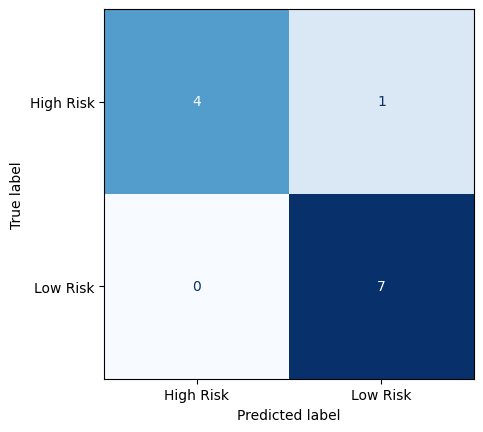

In [30]:
preds = all_glycoform_model.predict(X_test)
pred_proba = all_glycoform_model.predict_proba(X_test)

print (f'F1 score: {f1_score(y_test, preds, average="macro"):.3f}')
print (f'Accuracy: {accuracy_score(y_test, preds):.3f}')
print (f'AUC: {roc_auc_score(y_test, pred_proba[:,1]):.3f}')

conf_m = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay.from_predictions(y_test, preds,display_labels=["High Risk","Low Risk"],colorbar=False, cmap=plt.cm.Blues)
plt.show()

In [31]:
print(classification_report(y_test, preds))

print (precision_recall_fscore_support(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.88      1.00      0.93         7

    accuracy                           0.92        12
   macro avg       0.94      0.90      0.91        12
weighted avg       0.93      0.92      0.91        12

(array([1.   , 0.875]), array([0.8, 1. ]), array([0.88888889, 0.93333333]), array([5, 7], dtype=int64))


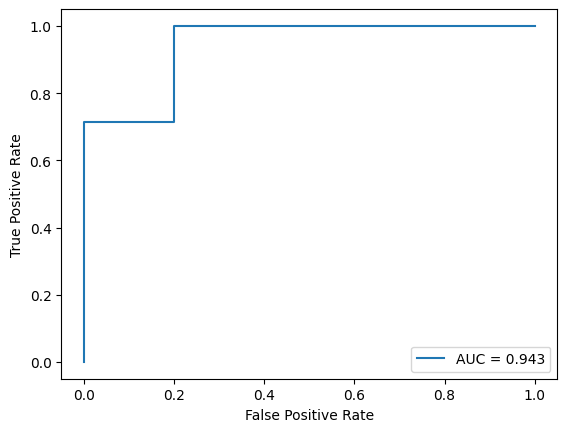

In [32]:
auc_preds = pred_proba[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  auc_preds)
auc = metrics.roc_auc_score(y_test, auc_preds)
label = f"AUC = {auc:.3f}"
plt.plot(fpr,tpr,label=label)


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.show()

### Glycotypes

In [27]:
score = 'roc_auc'

pipe = Pipeline(
    [
        ("scaling", StandardScaler()),
        ("select_features","passthrough"),
        ("sfs","passthrough"),
        ("classify", "passthrough"),
    ]
)

ALPHA_OPTIONS = np.arange(0.01, 0.22, 0.01) #np.arange(0.001, 0.106, 0.005)
N_FEATURES_OPTIONS = np.arange(1, 10, 2) #[5,10,15,20]
TOL_OPTIONS = [-0.001]#[-0.01,-0.001,-0.0001]
C_OPTIONS = [0.01, 0.1, 0.5, 1,2, 5, 10]  #np.arange(0.01, 5, 0.2)# 
GAMMA_OPTIONS = [0, 0.01, 0.1, 1, 5, 10]
KERNEL_OPTIONS = ['linear', 'poly', 'rbf', 'sigmoid']
N_NEIGHBORS_OPTIONS = np.arange(1, 20, 2)
MLP_ALPHA_OPTIONS = [10 ** -5, 10 ** -4, 10 ** -3]
SOLVER = ['lbfgs', 'sgd', 'adam']
HIDDEN_LAYERS = [(300,100,50), (100,)]
CRITERION_OPTIONS = ['gini', 'entropy', 'log_loss']
MIN_SAMPLES_SPLIT = [2, 3, 4, 5]
MIN_SAMPLES_LEAF = [1, 2, 3, 4, 5]
MIN_CHILD_WEIGHT = [0, 0.01, 0.1, 1, 5]


preset_grid = [
    {
        # 0.91444444 
        "select_features": [SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))],
        "select_features__estimator__alpha": [0.00006],
        "classify": [LogisticRegression(class_weight='balanced',random_state=random_seed)],
        "classify__C": [0.01]
    },
    {
        # 0.8852381  
        "select_features": [SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))],
        "select_features__estimator__alpha": [.0001,],
        "classify": [SVC(class_weight='balanced', random_state=random_seed, probability=True)],
        "classify__C": [0.01],
        "classify__kernel": ['poly']
    },
    {
        # 0.73746032
        "select_features": [SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))],
        "select_features__estimator__alpha": [.0001],
        "classify": [KNeighborsClassifier()], 
        "classify__n_neighbors": [17]
    },
    {
        # 0.90444444
        "select_features": [SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))],
        "select_features__estimator__alpha": [0.0001],
        "classify": [MLPClassifier(random_state=random_seed, max_iter=2000)],
        "classify__hidden_layer_sizes": [(100,100,)],
        "classify__solver": ['lbfgs']
    },
    {
        # 0.84206349  
        "select_features": [SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))],
        "select_features__estimator__alpha": [0.2],
        "classify": [RandomForestClassifier(class_weight='balanced', random_state=random_seed, n_estimators=500)],
        "classify__criterion": ['gini'],
        "classify__min_samples_split": [4],
        "classify__min_samples_leaf": [1]
    },
    {
        # 0.83301587
        "select_features": [SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))],
        "select_features__estimator__alpha": [0.2],
        "classify": [xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]))],
        "classify__gamma": [0],
        "classify__min_child_weight": [0.1]
    }
    ]

glycotype_model = GridSearchCV(pipe, n_jobs=-1, param_grid=preset_grid[0], cv=5, scoring=score, verbose=1, return_train_score=True)
glycotype_model.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('select_features', 'passthrough'),
                                       ('sfs', 'passthrough'),
                                       ('classify', 'passthrough')]),
             n_jobs=-1,
             param_grid={'classify': [LogisticRegression(class_weight='balanced',
                                                         random_state=42)],
                         'classify__C': [0.01],
                         'select_features': [SelectFromModel(estimator=Lasso(max_iter=5000,
                                                                             random_state=42))],
                         'select_features__estimator__alpha': [6e-05]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [28]:
print (f"Train: {glycotype_model.cv_results_['mean_train_score'][glycotype_model.cv_results_['rank_test_score'] == 1]}")
print (f"Test: {glycotype_model.cv_results_['mean_test_score'][glycotype_model.cv_results_['rank_test_score'] == 1]}")

Train: [1.]
Test: [0.91444444]


In [29]:
print (glycotype_model.best_score_)
print (glycotype_model.best_params_)
print (glycotype_model.best_estimator_)

0.9144444444444444
{'classify': LogisticRegression(class_weight='balanced', random_state=42), 'classify__C': 0.01, 'select_features': SelectFromModel(estimator=Lasso(max_iter=5000, random_state=42)), 'select_features__estimator__alpha': 6e-05}
Pipeline(steps=[('scaling', StandardScaler()),
                ('select_features',
                 SelectFromModel(estimator=Lasso(alpha=6e-05, max_iter=5000,
                                                 random_state=42))),
                ('sfs', 'passthrough'),
                ('classify',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    random_state=42))])


In [30]:
len(glycotype_model.best_estimator_[:-1].get_feature_names_out())

80

F1 score: 0.733
Accuracy: 0.750
AUC: 0.886


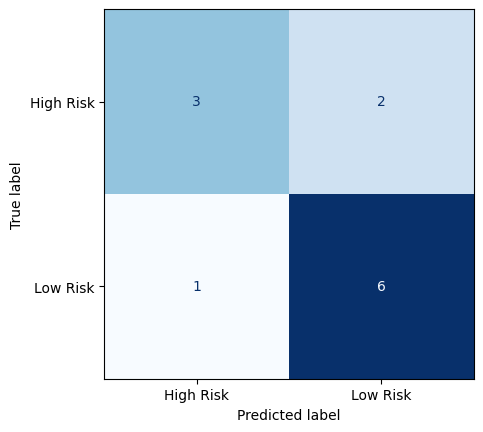

In [32]:
preds = glycotype_model.predict(X_test)
pred_proba = glycotype_model.predict_proba(X_test)

print (f'F1 score: {f1_score(y_test, preds, average="macro"):.3f}')
print (f'Accuracy: {accuracy_score(y_test, preds):.3f}')
print (f'AUC: {roc_auc_score(y_test, pred_proba[:,1]):.3f}')

conf_m = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay.from_predictions(y_test, preds,display_labels=["High Risk","Low Risk"],colorbar=False, cmap=plt.cm.Blues)
plt.show()

In [33]:
print(classification_report(y_test, preds))

print (precision_recall_fscore_support(y_test, preds))

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.75      0.86      0.80         7

    accuracy                           0.75        12
   macro avg       0.75      0.73      0.73        12
weighted avg       0.75      0.75      0.74        12

(array([0.75, 0.75]), array([0.6       , 0.85714286]), array([0.66666667, 0.8       ]), array([5, 7], dtype=int64))


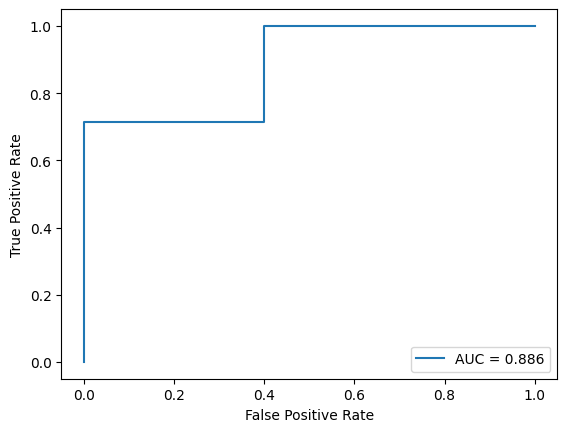

In [34]:
auc_preds = pred_proba[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  auc_preds)
auc = metrics.roc_auc_score(y_test, auc_preds)
label = f"AUC = {auc:.3f}"
plt.plot(fpr,tpr,label=label)


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.show()

### Glycosites

In [27]:
score = 'roc_auc'

pipe = Pipeline(
    [
        ("scaling", StandardScaler()),
        ("select_features","passthrough"),
        ("sfs","passthrough"),
        ("classify", "passthrough"),
    ]
)

ALPHA_OPTIONS = np.arange(0.01, 0.22, 0.01) #np.arange(0.001, 0.106, 0.005)
N_FEATURES_OPTIONS = np.arange(1, 10, 2) #[5,10,15,20]
TOL_OPTIONS = [-0.001]#[-0.01,-0.001,-0.0001]
C_OPTIONS = [0.01, 0.1, 0.5, 1,2, 5, 10]  #np.arange(0.01, 5, 0.2)# 
GAMMA_OPTIONS = [0, 0.01, 0.1, 1, 5, 10]
KERNEL_OPTIONS = ['linear', 'poly', 'rbf', 'sigmoid']
N_NEIGHBORS_OPTIONS = np.arange(1, 20, 2)
MLP_ALPHA_OPTIONS = [10 ** -5, 10 ** -4, 10 ** -3]
SOLVER = ['lbfgs', 'sgd', 'adam']
HIDDEN_LAYERS = [(300,100,50), (100,)]
CRITERION_OPTIONS = ['gini', 'entropy', 'log_loss']
MIN_SAMPLES_SPLIT = [2, 3, 4, 5]
MIN_SAMPLES_LEAF = [1, 2, 3, 4, 5]
MIN_CHILD_WEIGHT = [0, 0.01, 0.1, 1, 5]


preset_grid = [
    {
        # 0.89698413 
        "select_features": [SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))],
        "select_features__estimator__alpha": [.00001],
        "classify": [LogisticRegression(class_weight='balanced',random_state=random_seed)],
        "classify__C": [0.1]
    },
    {
        # 0.89698413
        "select_features": [SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))],
        "select_features__estimator__alpha": [.00001],
        "classify": [SVC(class_weight='balanced', random_state=random_seed, probability=True)],
        "classify__C": [0.5],
        "classify__kernel": ['sigmoid']
    },
    {
        # 0.88888889
        "select_features": [SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))],
        "select_features__estimator__alpha": [0.047],
        "classify": [KNeighborsClassifier()], 
        "classify__n_neighbors": [7]
    },
    {
        # 0.90492063
        "select_features": [SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))],
        "select_features__estimator__alpha": [0.0072],
        "classify": [MLPClassifier(random_state=random_seed, max_iter=2000)],
        "classify__hidden_layer_sizes": [(100,100,)],
        "classify__solver": ['sgd']
    },
    {
        # 0.82460317 
        "select_features": [SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))],
        "select_features__estimator__alpha": [0.06],
        "classify": [RandomForestClassifier(class_weight='balanced', random_state=random_seed, n_estimators=500)],
        "classify__criterion": ['gini'],
        "classify__min_samples_split": [2],
        "classify__min_samples_leaf": [3]
    },
    {
        # 0.82650794 
        "select_features": [SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))],
        "select_features__estimator__alpha": [0.06],
        "classify": [xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]))],
        "classify__gamma": [5],
        "classify__min_child_weight": [0]
    }
    ]

glycosite_model = GridSearchCV(pipe, n_jobs=-1, param_grid=preset_grid[3], cv=5, scoring=score, verbose=1, return_train_score=True)
glycosite_model.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('select_features', 'passthrough'),
                                       ('sfs', 'passthrough'),
                                       ('classify', 'passthrough')]),
             n_jobs=-1,
             param_grid={'classify': [MLPClassifier(max_iter=2000,
                                                    random_state=42)],
                         'classify__hidden_layer_sizes': [(100, 100)],
                         'classify__solver': ['sgd'],
                         'select_features': [SelectFromModel(estimator=Lasso(max_iter=5000,
                                                                             random_state=42))],
                         'select_features__estimator__alpha': [0.0072]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [28]:
print (f"Train: {glycosite_model.cv_results_['mean_train_score'][glycosite_model.cv_results_['rank_test_score'] == 1]}")
print (f"Test: {glycosite_model.cv_results_['mean_test_score'][glycosite_model.cv_results_['rank_test_score'] == 1]}")

Train: [1.]
Test: [0.90492063]


In [29]:
print (glycosite_model.best_score_)
print (glycosite_model.best_params_)
print (glycosite_model.best_estimator_)

0.9049206349206351
{'classify': MLPClassifier(max_iter=2000, random_state=42), 'classify__hidden_layer_sizes': (100, 100), 'classify__solver': 'sgd', 'select_features': SelectFromModel(estimator=Lasso(max_iter=5000, random_state=42)), 'select_features__estimator__alpha': 0.0072}
Pipeline(steps=[('scaling', StandardScaler()),
                ('select_features',
                 SelectFromModel(estimator=Lasso(alpha=0.0072, max_iter=5000,
                                                 random_state=42))),
                ('sfs', 'passthrough'),
                ('classify',
                 MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=2000,
                               random_state=42, solver='sgd'))])


In [30]:
len(sorted(glycosite_model.best_estimator_[:-1].get_feature_names_out()))

44

In [31]:
sorted(glycosite_model.best_estimator_[:-1].get_feature_names_out())

['ACE_445',
 'AGA_38',
 'ART4_274',
 'AZU1_126',
 'C1RL_166',
 'C9_277',
 'CELSR1_1640',
 'CEMIP2_914',
 'CES1_79',
 'CFHR3_309',
 'CPB2_44',
 'ECM1_444',
 'EGFR_413',
 'EMILIN2_616',
 'EMILIN2_745',
 'ENPP1_285',
 'FBLN1_98',
 'FLNA_1974',
 'FOLR1_69',
 'FOXRED2_502',
 'FREM2_2121',
 'GPLD1_568',
 'GPR107_70',
 'HP_241',
 'HSD11B1_162',
 'IL17RB_103',
 'ITGA6_323',
 'ITGAV_488',
 'JCHAIN_71',
 'LAMA1_1804',
 'MATN2_221',
 'MPO_391',
 'NOMO2_50',
 'NPR3_394',
 'NRP1_522',
 'ORM1_103',
 'ORM1_93',
 'PAPPA_429',
 'PRCP_415',
 'PZP_932',
 'SERPINA4_157',
 'SERPINA5_249',
 'TINAG_314',
 'UPK1B_131']

F1 score: 0.812
Accuracy: 0.833
AUC: 0.914


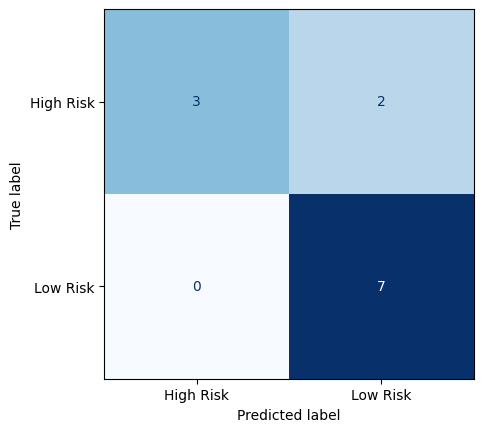

In [32]:
preds = glycosite_model.predict(X_test)
pred_proba = glycosite_model.predict_proba(X_test)

print (f'F1 score: {f1_score(y_test, preds, average="macro"):.3f}')
print (f'Accuracy: {accuracy_score(y_test, preds):.3f}')
print (f'AUC: {roc_auc_score(y_test, pred_proba[:,1]):.3f}')

conf_m = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay.from_predictions(y_test, preds,display_labels=["High Risk","Low Risk"],colorbar=False, cmap=plt.cm.Blues)
plt.show()

In [33]:
print(classification_report(y_test, preds))

print (precision_recall_fscore_support(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.78      1.00      0.88         7

    accuracy                           0.83        12
   macro avg       0.89      0.80      0.81        12
weighted avg       0.87      0.83      0.82        12

(array([1.        , 0.77777778]), array([0.6, 1. ]), array([0.75 , 0.875]), array([5, 7], dtype=int64))


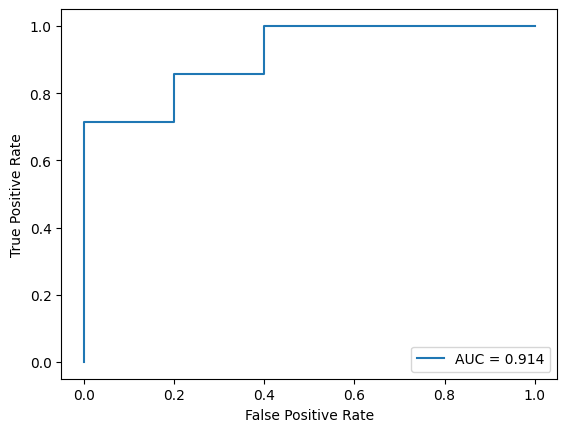

In [34]:
auc_preds = pred_proba[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  auc_preds)
auc = metrics.roc_auc_score(y_test, auc_preds)
label = f"AUC = {auc:.3f}"
plt.plot(fpr,tpr,label=label)


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.show()

## Feature Importance

In [33]:
all_glycoform_model.best_estimator_

Pipeline(steps=[('scaling', StandardScaler()),
                ('select_features',
                 SelectFromModel(estimator=Lasso(alpha=0.0003, max_iter=5000,
                                                 random_state=42))),
                ('sfs', 'passthrough'),
                ('classify', MLPClassifier(max_iter=2000, random_state=42))])

In [ ]:
# Summary Plot
explainer = shap.KernelExplainer(all_glycoform_model.best_estimator_['classify'].predict_proba, all_glycoform_model.best_estimator_['select_features'].transform(all_glycoform_model.best_estimator_['scaling'].transform(X_train)))
shap_values = explainer.shap_values(all_glycoform_model.best_estimator_['select_features'].transform(all_glycoform_model.best_estimator_['scaling'].transform(X)))

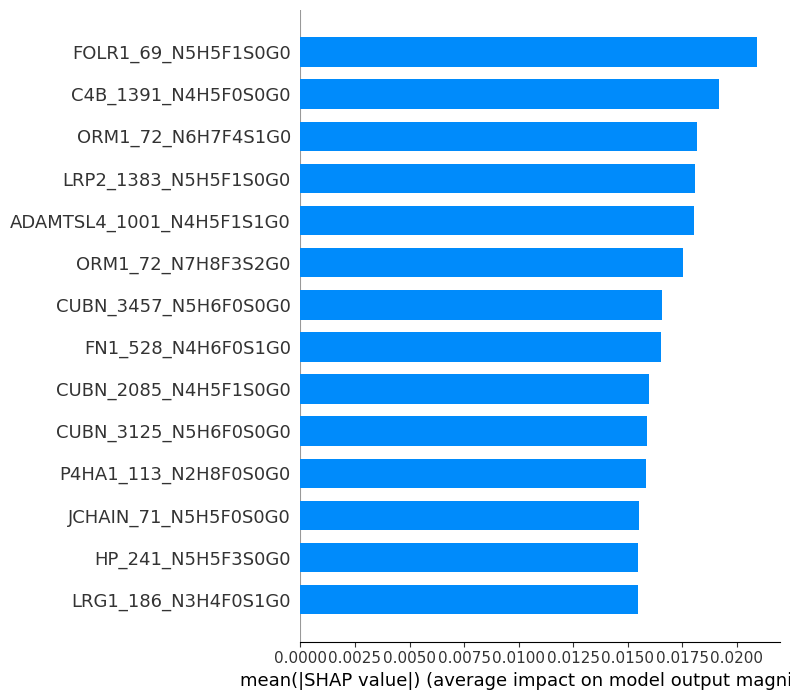

In [51]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names=all_glycoform_model.best_estimator_[:-1].get_feature_names_out(), max_display=14)

In [47]:
shap_values_sorted = abs(pd.DataFrame(shap_values[0], columns=all_glycoform_model.best_estimator_[:-1].get_feature_names_out())).mean(axis=0).sort_values(ascending=False)
shap_values_sorted.describe()

count    53.000000
mean      0.011800
std       0.004193
min       0.003820
25%       0.008824
50%       0.010897
75%       0.015454
max       0.020940
dtype: float64

In [50]:
len(shap_values_sorted[shap_values_sorted>0.015454])

14

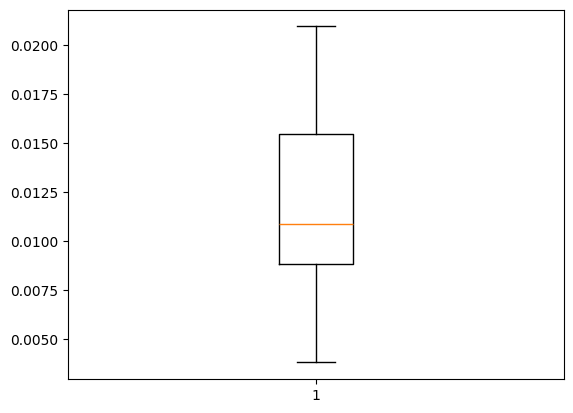

In [68]:
plt.boxplot(shap_values_sorted)

# show plot
plt.show()

In [71]:
shap_values_sorted.to_csv('shap_values.csv',index=True)

In [ ]:
# https://datascience.stackexchange.com/questions/52476/how-to-use-shap-kernal-explainer-with-pipeline-models

#explainer = shap.KernelExplainer(grid.best_estimator_['classify'].predict_proba, grid.best_estimator_['reduce_dim'].transform(grid.best_estimator_['scaling'].transform(X_train)))
#shap_values = explainer.shap_values(grid.best_estimator_['reduce_dim'].transform(grid.best_estimator_['scaling'].transform(X_test)))
#shap.summary_plot(shap_values[0], plot_type='bar', feature_names=grid.best_estimator_[:-1].get_feature_names_out())

## Feature Distribution

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statannotations.Annotator import Annotator


def print_n_projects(df, df_name="the dataset"):
    print(f"There are {df.shape[0]} projects in {df_name}.")
    
    
def describe_array(array: np.array, name=None, min_len=15):
    name = f"\"{name}\"".ljust(min_len) if name is not None else ''
    print(f"{name}Number of projects: {len(array)}" + "\t" 
          + f"Min: {array.min():.2f}" + "\t"
          + f"Max: {array.max():.2e}" + "\t"
          + f"Avg: {array.mean():.2f}" + "\t"
          + f"Median: {np.percentile(array, 50):.2e}")
    
    
def get_projects_by(df, row_name, func):
    """Returns a list of projects, sorted by `func` result by `Subcategory`"""
    # noinspection PyUnresolvedReferences
    func = getattr(pd.core.groupby.generic.DataFrameGroupBy, func)
    grouped_df = (func(df.groupby("Subcategory"))
                  .sort_values(by=row_name, ascending=False)
                  .reset_index())
    ans = []
    for index, row in grouped_df.iterrows():
        ans.append(
            f"{index+1}. {row.Subcategory.ljust(20-(index+1)//10)} "
            f"{row[[row_name]].values[0]:.2e}")
    return ans


def print_projects_by(df, row_name, func):
    """Prints a list of projects, sorted by `func` result by `Subcategory`"""
    projects = get_projects_by(df, row_name, func)
    print("\n".join(projects))
    
    
def label_plot_for_subcats(ax):
    plt.title("Glycopeptide Distribution", y=1.06)
    ax.set_ylabel("Abundance")
    ax.set_xlabel("Glycopeptide", labelpad=20)
    ax.set
    
    
def get_log_ax(orient="v"):
    if orient == "v":
        figsize = (12, 6)
        set_scale = "set_yscale"
    else:
        figsize = (10, 8)
        set_scale = "set_xscale"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    #fig.patch.set_alpha(1)
    #getattr(ax, set_scale)("log")
    return ax


def add_legend(ax):
    ax.legend(loc=(1.05, 0.5))

In [46]:
values = pd.concat([
    df_model["FOLR1_69_N5H5F1S0G0"],
    df_model["C4B_1391_N4H5F0S0G0"],
    df_model["ORM1_72_N6H7F4S1G0"],
    df_model["LRP2_1383_N5H5F1S0G0"],
    df_model["ADAMTSL4_1001_N4H5F1S1G0"],
    df_model["ORM1_72_N7H8F3S2G0"],
    df_model["CUBN_3457_N5H6F0S0G0"],
    df_model["FN1_528_N4H6F0S1G0"],
    df_model["CUBN_2085_N4H5F1S0G0"],
    df_model["CUBN_3125_N5H6F0S0G0"],
    df_model["P4HA1_113_N2H8F0S0G0"],
    df_model["JCHAIN_71_N5H5F0S0G0"],
    df_model["HP_241_N5H5F3S0G0"],
    df_model["LRG1_186_N3H4F0S1G0"],
    ],axis=0)
values = pd.concat([values,df_model["risk"]],axis=1)

In [47]:
gp_list = []
for gp in ["FOLR1_69_N5H5F1S0G0",
           "C4B_1391_N4H5F0S0G0",
           "ORM1_72_N6H7F4S1G0",
           "LRP2_1383_N5H5F1S0G0",
           "ADAMTSL4_1001_N4H5F1S1G0",
           "ORM1_72_N7H8F3S2G0",
           "CUBN_3457_N5H6F0S0G0",
           "FN1_528_N4H6F0S1G0",
           "CUBN_2085_N4H5F1S0G0",
           "CUBN_3125_N5H6F0S0G0",
           "P4HA1_113_N2H8F0S0G0",
           "JCHAIN_71_N5H5F0S0G0",
           "HP_241_N5H5F3S0G0",
           "LRG1_186_N3H4F0S1G0"
           ]:
    for i in range(len(df_model)):
        gp_list.append(gp)
        
df_stats = pd.concat([pd.Series(gp_list),values.reset_index(drop=True)],axis=1)
df_stats.columns = ["GP","abs","risk"]
df_stats

,GP,abs,risk
0,FOLR1_69_N5H5F1S0G0,15.223809,0
1,FOLR1_69_N5H5F1S0G0,13.589701,0
2,FOLR1_69_N5H5F1S0G0,12.285297,1
3,FOLR1_69_N5H5F1S0G0,12.507171,1
4,FOLR1_69_N5H5F1S0G0,15.516078,0
...,...,...,...
807,LRG1_186_N3H4F0S1G0,16.809384,0
808,LRG1_186_N3H4F0S1G0,16.277191,1
809,LRG1_186_N3H4F0S1G0,17.657286,0
810,LRG1_186_N3H4F0S1G0,16.850012,0


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CUBN_3125_N5H6F0S0G0_0 vs. CUBN_3125_N5H6F0S0G0_1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.491e-06 U_stat=1.270e+02
P4HA1_113_N2H8F0S0G0_0 vs. P4HA1_113_N2H8F0S0G0_1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.490e-04 U_stat=6.350e+02
JCHAIN_71_N5H5F0S0G0_0 vs. JCHAIN_71_N5H5F0S0G0_1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.080e-04 U_stat=1.930e+02
HP_241_N5H5F3S0G0_0 vs. HP_241_N5H5F3S0G0_1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.538e-02 U_stat=5.620e+02
LRG1_186_N3H4F0S1G0_0 vs. LRG1_186_N3H4F0S1G0_1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.376e-03 U_stat=5.890e+02
CUBN_2085_N4H5F1S0G0_0 vs. CUBN_2085_N4H5F

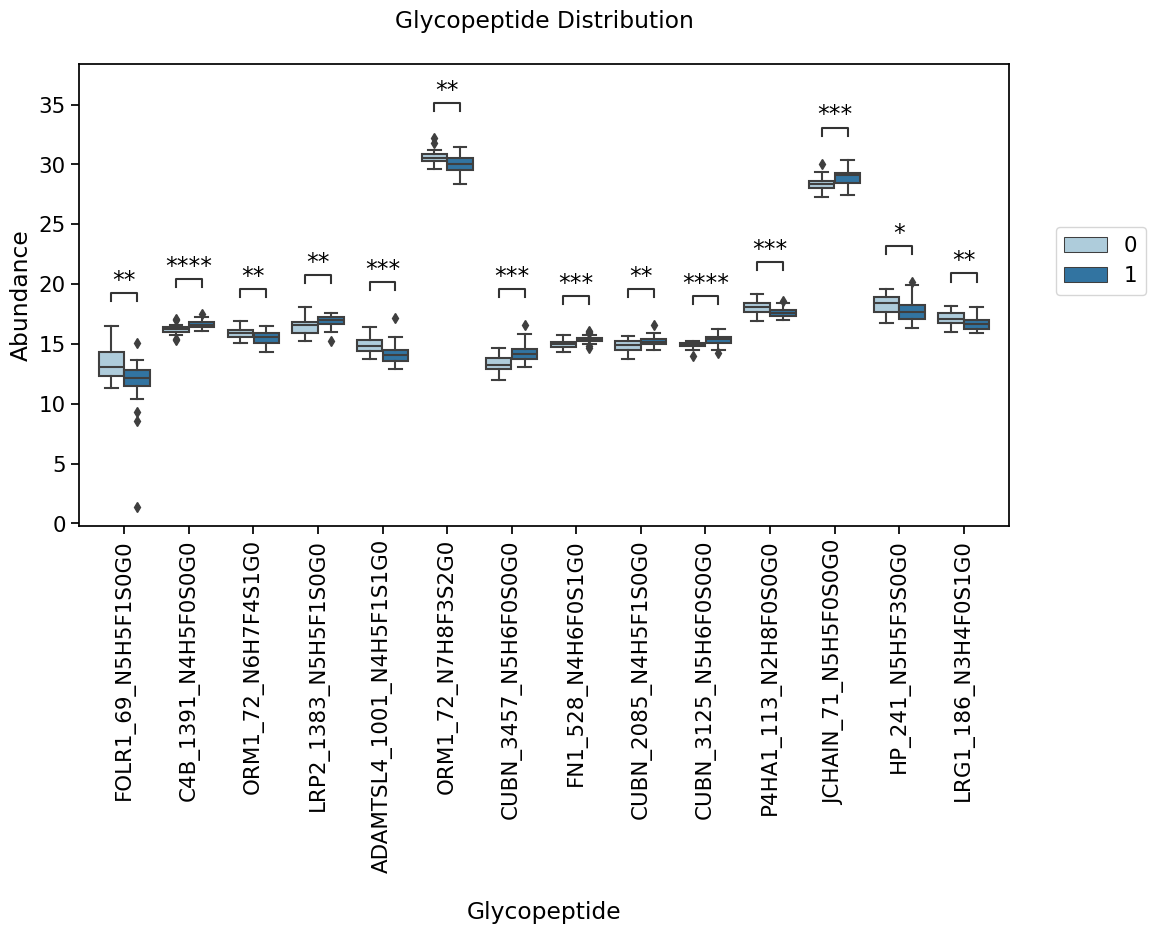

In [48]:
#https://levelup.gitconnected.com/statistics-on-seaborn-plots-with-statannotations-2bfce0394c00

subcat_order = ["FOLR1_69_N5H5F1S0G0",
           "C4B_1391_N4H5F0S0G0",
           "ORM1_72_N6H7F4S1G0",
           "LRP2_1383_N5H5F1S0G0",
           "ADAMTSL4_1001_N4H5F1S1G0",
           "ORM1_72_N7H8F3S2G0",
           "CUBN_3457_N5H6F0S0G0",
           "FN1_528_N4H6F0S1G0",
           "CUBN_2085_N4H5F1S0G0",
           "CUBN_3125_N5H6F0S0G0",
           "P4HA1_113_N2H8F0S0G0",
           "JCHAIN_71_N5H5F0S0G0",
           "HP_241_N5H5F3S0G0",
           "LRG1_186_N3H4F0S1G0"]
subcat_palette = sns.color_palette("Paired")

plotting_parameters = {
    'data':    df_stats,
    'x':       'GP',
    'y':       'abs',
    "order": subcat_order,
    'hue': 'risk',
    'palette': subcat_palette
}

pairs = [
    [('FOLR1_69_N5H5F1S0G0', 0), ('FOLR1_69_N5H5F1S0G0', 1)],  
    [('C4B_1391_N4H5F0S0G0', 0), ('C4B_1391_N4H5F0S0G0', 1)],   
    [('ORM1_72_N6H7F4S1G0', 0), ('ORM1_72_N6H7F4S1G0', 1)],
    [('LRP2_1383_N5H5F1S0G0', 0), ('LRP2_1383_N5H5F1S0G0', 1)],
    [('ADAMTSL4_1001_N4H5F1S1G0', 0), ('ADAMTSL4_1001_N4H5F1S1G0', 1)],
    [('ORM1_72_N7H8F3S2G0', 0), ('ORM1_72_N7H8F3S2G0', 1)],
    [('CUBN_3457_N5H6F0S0G0', 0), ('CUBN_3457_N5H6F0S0G0', 1)],
    [('FN1_528_N4H6F0S1G0', 0), ('FN1_528_N4H6F0S1G0', 1)],
    [('CUBN_2085_N4H5F1S0G0', 0), ('CUBN_2085_N4H5F1S0G0', 1)],
    [('CUBN_3125_N5H6F0S0G0', 0), ('CUBN_3125_N5H6F0S0G0', 1)],
    [('P4HA1_113_N2H8F0S0G0', 0), ('P4HA1_113_N2H8F0S0G0', 1)],
    [('JCHAIN_71_N5H5F0S0G0', 0), ('JCHAIN_71_N5H5F0S0G0', 1)],
    [('HP_241_N5H5F3S0G0', 0), ('HP_241_N5H5F3S0G0', 1)],
    [('LRG1_186_N3H4F0S1G0', 0), ('LRG1_186_N3H4F0S1G0', 1)],
    ] 

with sns.plotting_context('notebook', font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    ax = sns.boxplot(ax=ax, **plotting_parameters)

    # Add annotations
    annotator = Annotator(ax, pairs, **plotting_parameters)
    #annotator.configure(test="Mann-Whitney").apply_and_annotate()
    annotator.configure(test="Mann-Whitney", comparisons_correction="BH")
    _, corrected_results = annotator.apply_and_annotate()

    # Label and show
    add_legend(ax)
    label_plot_for_subcats(ax)
    plt.xticks(rotation=90) 
    plt.show()

In [306]:
protein_list = []

for i in df_model.columns:
    #if "LRP2" == i.split("_")[0]:
    if "LRG1" in i.split("_N")[0]:
        protein_list.append(i.split("_N")[0])

sorted(set(protein_list))

['LRG1_186', 'LRG1_306', 'LRG1_325']

In [325]:
protein = "HP"
value_list = []
protein_list = []

for i in df_model.columns:
    if protein == i.split("_")[0] and "241" == i.split("_")[1]:
        value_list.append(df_model[i])
        protein_list.append(i)

values = pd.concat(value_list,axis=0)
values = pd.concat([values,df_model["risk"]],axis=1)

In [326]:
gp_list = []

for gp in protein_list:
    for i in range(len(df_model)):
        gp_list.append(gp)
        
df_stats = pd.concat([pd.Series(gp_list),values.reset_index(drop=True)],axis=1)
df_stats.columns = ["GP","abs","risk"]
df_stats

,GP,abs,risk
0,HP_241_N4H4F0S1G0,16.408367,High
1,HP_241_N4H4F0S1G0,15.559426,High
2,HP_241_N4H4F0S1G0,16.055282,Low
3,HP_241_N4H4F0S1G0,16.583277,Low
4,HP_241_N4H4F0S1G0,16.344879,High
...,...,...,...
2663,HP_241_N5H6F3S1G0,15.707483,High
2664,HP_241_N5H6F3S1G0,15.362278,Low
2665,HP_241_N5H6F3S1G0,16.126452,High
2666,HP_241_N5H6F3S1G0,16.395399,High


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HP_241_N6H3F1S2G0_High vs. HP_241_N6H3F1S2G0_Low: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.459e-01 U_stat=4.820e+02
HP_241_N5H6F0S1G0_High vs. HP_241_N5H6F0S1G0_Low: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.808e-01 U_stat=3.980e+02
HP_241_N5H7F1S2G0_High vs. HP_241_N5H7F1S2G0_Low: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.988e-02 (ns) U_stat=5.560e+02
HP_241_N5H6F0S2G0_High vs. HP_241_N5H6F0S2G0_Low: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.571e-02 U_stat=5.210e+02
HP_241_N5H7F1S1G0_High vs. HP_241_N5H7F1S1G0_Low: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.898e-02 U_stat=5.130e+02
HP_241_N5H6F1S1G0_High vs. HP_241_

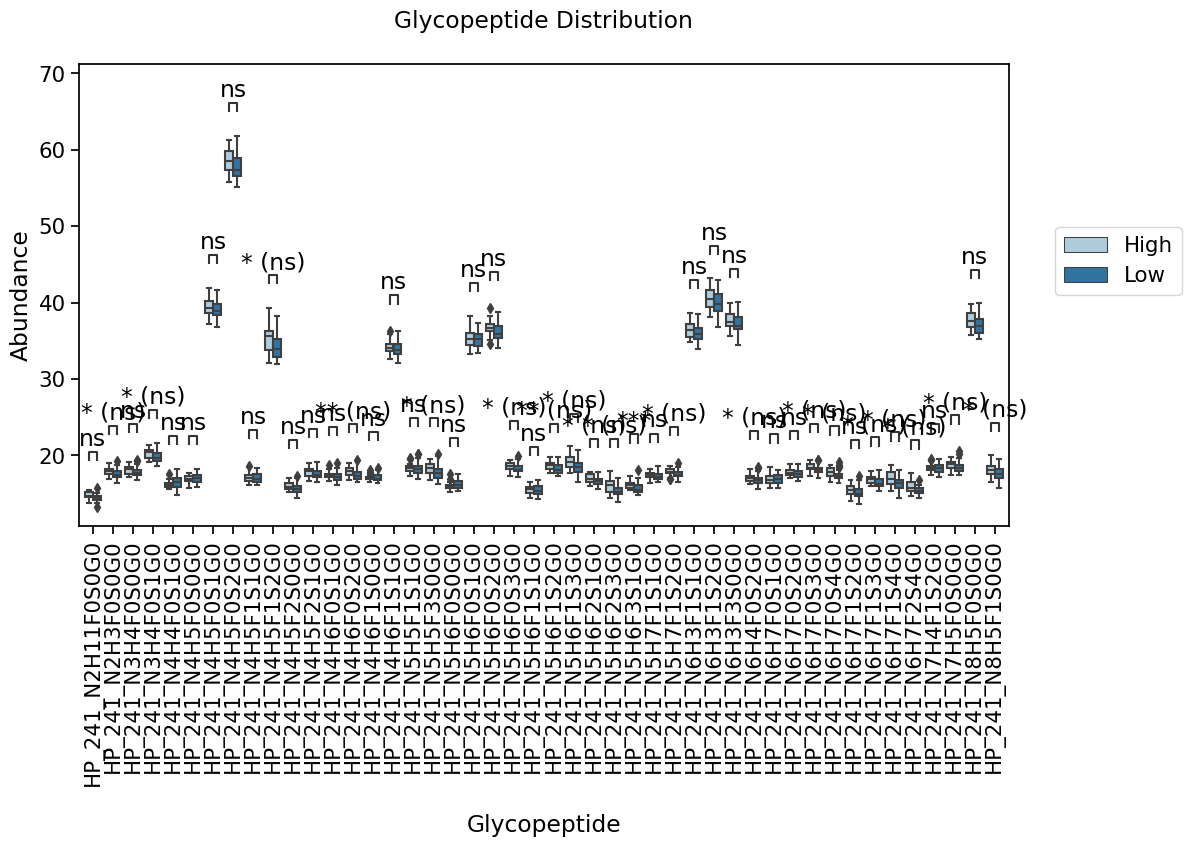

In [327]:
#https://levelup.gitconnected.com/statistics-on-seaborn-plots-with-statannotations-2bfce0394c00

subcat_order = sorted(protein_list)
subcat_palette = sns.color_palette("Paired")

plotting_parameters = {
    'data':    df_stats,
    'x':       'GP',
    'y':       'abs',
    "order": subcat_order,
    'hue': 'risk',
    'palette': subcat_palette
}

pairs = []
for i in protein_list:
    i_list = [(i, "High"), (i, "Low")]
    pairs.append(i_list)

with sns.plotting_context('notebook', font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    ax = sns.boxplot(ax=ax, **plotting_parameters)

    # Add annotations
    annotator = Annotator(ax, pairs, **plotting_parameters)
    #annotator.configure(test="Mann-Whitney").apply_and_annotate()
    annotator.configure(test="Mann-Whitney", comparisons_correction="BH")
    _, corrected_results = annotator.apply_and_annotate()

    # Label and show
    add_legend(ax)
    label_plot_for_subcats(ax)
    plt.xticks(rotation=90) 
    plt.show()

## Plots

In [243]:
CTSD_list = ["risk"]

for i in df_model.columns:
    if "LRP1" == i.split("_")[0]:
        CTSD_list.append(i)

CTSD_df = df_model[CTSD_list]
CTSD_df.columns

plot_glycoform_df = {'risk':[],'Abundance':[], 'Type':[]}

for i in CTSD_df.columns[1:]:
    for j in CTSD_df[i].to_list():
        plot_glycoform_df['Abundance'].append(j)
        plot_glycoform_df['Type'].append("LRP1")
    for h in CTSD_df['risk'].to_list():
        plot_glycoform_df['risk'].append(h)
    

In [244]:
CTSD_list = ["risk"]

for i in df_model.columns:
    if "LRP1_1645_" in i:
        CTSD_list.append(i)

CTSD_df = df_model[CTSD_list]
CTSD_df.columns

for i in CTSD_df.columns[1:]:
    for j in CTSD_df[i].to_list():
        plot_glycoform_df['Abundance'].append(j)
        plot_glycoform_df['Type'].append("LRP1_1645")
    for h in CTSD_df['risk'].to_list():
        plot_glycoform_df['risk'].append(h)
    

In [222]:

for i in CTSD_df.columns[1:]:
    for j in CTSD_df[i].to_list():
        plot_glycoform_df['Abundance'].append(j)
        if "F0" not in i.split("_")[-1]:
            plot_glycoform_df['Type'].append("CTSD_263_fucosylated")
        elif "S0" not in i.split("_")[-1]:
            plot_glycoform_df['Type'].append("CTSD_263_sialylated")
        else:
            if "N2" in i.split("_")[-1]:
                plot_glycoform_df['Type'].append("CTSD_263_highmannose")
            else: 
                plot_glycoform_df['Type'].append("CTSD_263_complex")

        #elif i.split("_")[-1] in ["N2H9F0S0G0","N2H8F0S0G0","N2H7F0S0G0","N2H6F0S0G0","N2H5F0S0G0"]:
        #    plot_glycoform_df['Type'].append("highmannose")
        #else:
        #    plot_glycoform_df['Type'].append("Other")
    for h in CTSD_df['risk'].to_list():
        plot_glycoform_df['risk'].append(h)

In [245]:
CTSD_list = ["risk"]

for i in df_model.columns:
    if "LRP1_1645_AFInGTGVETVVSADLPNAHGLAVDWVSR_N4H5F0S0G0" in i:
        CTSD_list.append(i)

CTSD_df = df_model[CTSD_list]
CTSD_df.columns

for i in CTSD_df.columns[1:]:
    for j in CTSD_df[i].to_list():
        plot_glycoform_df['Abundance'].append(j)
        plot_glycoform_df['Type'].append("LRP1_1645_N4H5F0S0G0")
    for h in CTSD_df['risk'].to_list():
        plot_glycoform_df['risk'].append(h)


In [224]:
CTSD_list = ["risk"]

for i in df_model.columns:
    if "CTSD_263_GSLSYLnVTR_N2H6F0S0G0" in i:
        CTSD_list.append(i)

CTSD_df = df_model[CTSD_list]
CTSD_df.columns

for i in CTSD_df.columns[1:]:
    for j in CTSD_df[i].to_list():
        plot_glycoform_df['Abundance'].append(j)
        plot_glycoform_df['Type'].append("CTSD_263_N2H6F0S0G0")
    for h in CTSD_df['risk'].to_list():
        plot_glycoform_df['risk'].append(h)

In [225]:
CTSD_list = ["risk"]

for i in df_model.columns:
    if "CTSD_263_GSLSYLnVTR_N2H7F0S0G0" in i:
        CTSD_list.append(i)

CTSD_df = df_model[CTSD_list]
CTSD_df.columns

for i in CTSD_df.columns[1:]:
    for j in CTSD_df[i].to_list():
        plot_glycoform_df['Abundance'].append(j)
        plot_glycoform_df['Type'].append("CTSD_263_N2H7F0S0G0")
    for h in CTSD_df['risk'].to_list():
        plot_glycoform_df['risk'].append(h)

In [226]:
CTSD_list = ["risk"]

for i in df_model.columns:
    if "CTSD_263_GSLSYLnVTR_N2H8F0S0G0" in i:
        CTSD_list.append(i)

CTSD_df = df_model[CTSD_list]
CTSD_df.columns

for i in CTSD_df.columns[1:]:
    for j in CTSD_df[i].to_list():
        plot_glycoform_df['Abundance'].append(j)
        plot_glycoform_df['Type'].append("CTSD_263_N2H8F0S0G0")
    for h in CTSD_df['risk'].to_list():
        plot_glycoform_df['risk'].append(h)

In [227]:
CTSD_list = ["risk"]

for i in df_model.columns:
    if "CTSD_263_GSLSYLnVTR_N2H9F0S0G0" in i:
        CTSD_list.append(i)

CTSD_df = df_model[CTSD_list]
CTSD_df.columns

for i in CTSD_df.columns[1:]:
    for j in CTSD_df[i].to_list():
        plot_glycoform_df['Abundance'].append(j)
        plot_glycoform_df['Type'].append("CTSD_263_N2H9F0S0G0")
    for h in CTSD_df['risk'].to_list():
        plot_glycoform_df['risk'].append(h)

In [246]:
plot_glycoform_df_combined = pd.DataFrame(plot_glycoform_df)#.sort_values(by="Type")
#plot_glycoform_df_combined = plot_glycoform_df_combined[plot_glycoform_df_combined['Type']!='CTSD_263_fucosylated']
#plot_glycoform_df_combined = plot_glycoform_df_combined[plot_glycoform_df_combined['Type']!='CTSD_263_sialylated']
#plot_glycoform_df_combined = plot_glycoform_df_combined[plot_glycoform_df_combined['Type']!='CTSD_263_complex']
#plot_glycoform_df_combined = plot_glycoform_df_combined[plot_glycoform_df_combined['Type']!='CTSD']
#plot_glycoform_df_combined = plot_glycoform_df_combined[plot_glycoform_df_combined['Type']!='CTSD_263']
#plot_glycoform_df_combined = plot_glycoform_df_combined[plot_glycoform_df_combined['Type']!='CTSD_263_highmannose']




In [247]:
from scipy import stats

data = []

for type in plot_glycoform_df_combined['Type'].unique():
    data.append(plot_glycoform_df_combined[(plot_glycoform_df_combined["risk"]=="Low") & (plot_glycoform_df_combined["Type"]==type)]["Abundance"])
    data.append(plot_glycoform_df_combined[(plot_glycoform_df_combined["risk"]=="High") & (plot_glycoform_df_combined["Type"]==type)]["Abundance"])

    # Initialise a list of combinations of groups that are significantly different
significant_combinations = []
    # Check from the outside pairs of boxes inwards
ls = list(range(1, len(data) + 1))
combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]

stats_list = []
count = 1
for i in range(len(plot_glycoform_df_combined['Type'].unique())):
    tup = (count,count+1)
    stats_list.append(tup)
    count += 2

for combination in combinations:
    data1 = data[combination[0] - 1]
    data2 = data[combination[1] - 1]
    # Significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    if p < 0.05 and combination in stats_list:
        significant_combinations.append([combination, p])

print (significant_combinations)

[[(1, 2), 6.142067911757842e-18], [(3, 4), 5.2469052340003e-07], [(5, 6), 5.244579454574958e-06]]


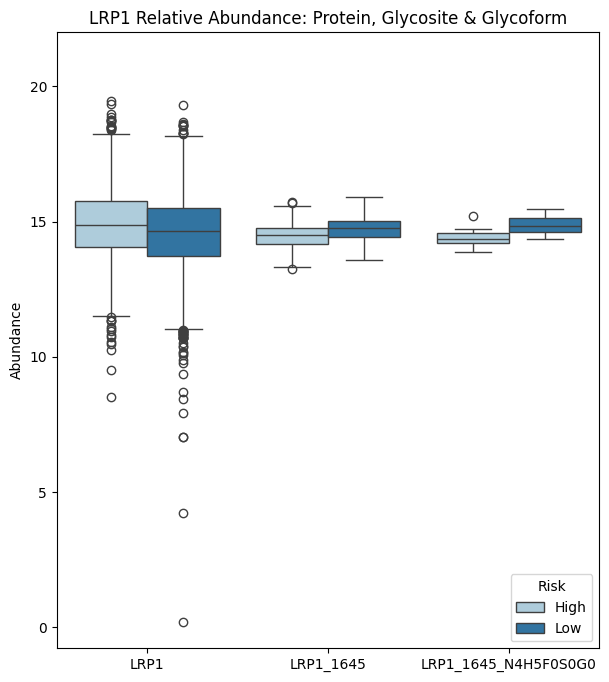

In [251]:
fig, ax = plt.subplots(figsize=(7, 8))
sns.boxplot(data=plot_glycoform_df_combined, hue="risk", x="Type", y="Abundance",palette="Paired")

plt.title("LRP1 Relative Abundance: Protein, Glycosite & Glycoform")
plt.xlabel("")
plt.legend(loc="lower right",title="Risk")
plt.ylim(top=22)
plt.xticks(rotation=0)
        
plt.show()